band_signals shape: (128, 60560)


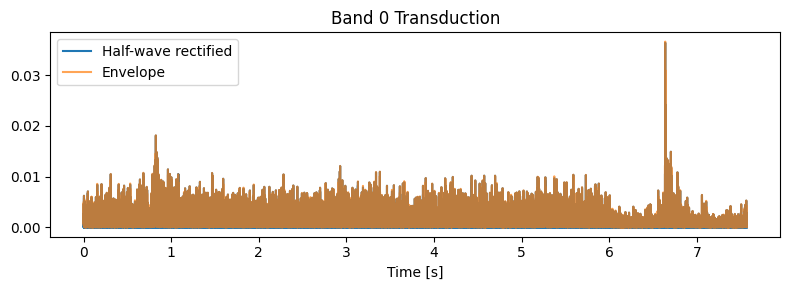

In [24]:
import numpy as np
import soundfile as sf
from gammatone.filters import make_erb_filters, erb_filterbank, centre_freqs  # centre_freqs 추가
from gammatone.gtgram import gtgram
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# 1) 오디오 로드
audio, sr = sf.read("MiniLibriMix/train/mix/14-212-0013_7926-254949-0054.wav")
gt_spec = gtgram(audio, sr, 0.025, 0.010, 128, 50, 8000)  # (신호, 샘플링, 윈도우, 스텝, 필터 수, 저주파, 고주파)

# 2) 128채널 ERB 중심 주파수 생성 (50Hz–Nyquist)
n_channels = 128
cfs = centre_freqs(sr, n_channels, 50, sr/2)  # positional args: sr, 채널 수, 시작 주파수, 끝 주파수

# 3) ERB 필터뱅크 계수 생성 (fs, 중심주파수 리스트)
erb_filters = make_erb_filters(sr, cfs)

# 4) 필터 출력 계산: (128, n_samples)
band_signals = erb_filterbank(audio, erb_filters)
print("band_signals shape:", band_signals.shape)  
# → (128, 60560) 이 나와야 합니다.

# 5) 0번 밴드 절반파 정류 + 엔벨롭
band0     = band_signals[0]
rectified = np.maximum(band0, 0)
envelope  = np.abs(hilbert(rectified))

# 6) 시각화
times = np.arange(len(band0)) / sr
plt.figure(figsize=(8,3))
plt.plot(times, rectified, label='Half-wave rectified')
plt.plot(times, envelope,  label='Envelope', alpha=0.7)
plt.xlabel('Time [s]')
plt.title('Band 0 Transduction')
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
gt_spec.shape

(128, 755)

In [26]:
import numpy as np
from scipy.signal import hilbert

# gt_spec: (n_channels, n_frames) 형태의 Gammatone spectrogram이 주어졌다고 가정

# 1. Half-wave rectification (음의 값을 0으로 잘라냄)
#    → 사람 귀의 외유모세포 반응을 모사
rectified = np.maximum(gt_spec, 0)  # shape: (128, T)
print(rectified.shape)

# 2. Hilbert transform을 통해 envelope 추출
#    → 각 밴드별 진폭의 윤곽선을 구함
analytic = hilbert(rectified, axis=1)  # 복소수 analytic signal
envelopes = np.abs(analytic)           # 진폭 envelope. shape: (128, T)

# 결과:
# envelopes[i, :]는 i번째 주파수 밴드의 시간에 따른 envelope입니다.


(128, 755)


In [27]:
import numpy as np
from scipy.signal import hilbert, firwin, lfilter

# --- (이전까지의 envelopes 계산) ---
# rectified = np.maximum(gt_spec, 0)
# analytic  = hilbert(rectified, axis=1)
# envelopes = np.abs(analytic)           # shape: (128, T)

# 3) LPF + Kaiser 윈도우 설계
sr = 8000  # 예시: 실제 sr 값으로 바꿔주세요
cutoff = 1000.0  # 1 kHz
win_duration = 0.01825  # 18.25 ms

# 필터 탭 수 (샘플 수) 계산
numtaps = int(np.ceil(win_duration * sr))
# FIR 필터는 홀수 길이 권장
if numtaps % 2 == 0:
    numtaps += 1

# Kaiser 파라미터 (beta): 5 정도가 무난
beta = 5.0

# FIR 저역통과 필터 계수 생성
lpf_coeffs = firwin(
    numtaps,
    cutoff=cutoff,
    window=('kaiser', beta),
    fs=sr
)

# 4) 각 밴드(envelope)에 필터 적용
#    axis=1 로 각 채널의 time축 방향으로 lfilter 실행
envelopes_lpf = lfilter(lpf_coeffs, [1.0], envelopes, axis=1)

# 결과 형태 확인
print("Original envelopes shape:", envelopes.shape)
print("Filtered envelopes shape:", envelopes_lpf.shape)


Original envelopes shape: (128, 755)
Filtered envelopes shape: (128, 755)


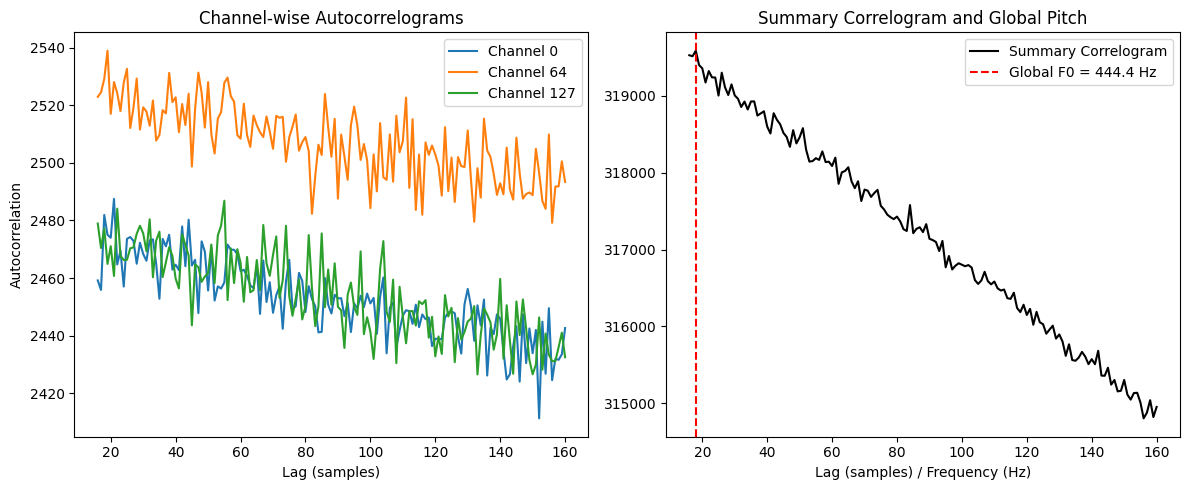

Estimated global pitch: 444.4 Hz (lag = 18 samples)


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터: envelopes_lpf (n_channels, T), sr (샘플링 레이트)
# 실제 구현에서는 앞 단계에서 얻은 envelopes_lpf과 sr을 사용하세요.
# 여기서는 envelopes_lpf를 임의로 생성해서 예시를 보여드립니다.
n_channels = 128
T = 10000  # 예시 프레임 수
sr = 8000
envelopes_lpf = np.random.rand(n_channels, T)  # 예시 데이터

# 피치 추정 범위 설정 (Hz)
min_f0 = 50
max_f0 = 500

# 대응하는 lag 범위 (샘플 단위)
min_lag = int(sr / max_f0)
max_lag = int(sr / min_f0)
lags = np.arange(min_lag, max_lag + 1)

# 1) 각 채널별 autocorrelation 계산
auto_per_channel = []
for ch in range(n_channels):
    env = envelopes_lpf[ch]
    corr_full = np.correlate(env, env, mode='full')
    corr = corr_full[corr_full.size // 2:]  # 양의 lag만
    auto_per_channel.append(corr[lags])

auto_per_channel = np.array(auto_per_channel)  # shape: (n_channels, len(lags))

# 2) 요약 correlogram: 채널 합산
summary_correlogram = np.sum(auto_per_channel, axis=0)

# 3) 전역 피치 (global pitch) 추출: 최대 피크 지점
peak_idx = np.argmax(summary_correlogram)
pitch_lag = lags[peak_idx]
global_f0 = sr / pitch_lag

# 4) 시각화
plt.figure(figsize=(12, 5))

# (a) 일부 채널들의 autocorrelogram
plt.subplot(1, 2, 1)
for ch in [0, n_channels//2, n_channels-1]:
    plt.plot(lags, auto_per_channel[ch], label=f'Channel {ch}')
plt.xlabel('Lag (samples)')
plt.ylabel('Autocorrelation')
plt.title('Channel-wise Autocorrelograms')
plt.legend()

# (b) 요약 correlogram과 전역 피치 표시
plt.subplot(1, 2, 2)
plt.plot(lags, summary_correlogram, label='Summary Correlogram', color='black')
plt.axvline(pitch_lag, color='red', linestyle='--', label=f'Global F0 = {global_f0:.1f} Hz')
# X축을 주파수 도메인으로 변환
freqs = sr / lags
plt.xlabel('Lag (samples) / Frequency (Hz)')
plt.title('Summary Correlogram and Global Pitch')
plt.legend()

plt.tight_layout()
plt.show()

# 결과 출력
print(f"Estimated global pitch: {global_f0:.1f} Hz (lag = {pitch_lag} samples)")


In [30]:
import numpy as np
from collections import defaultdict

# --- Assumed available from previous steps ---
# segments: list of dicts with keys 'id', 'channel', 'start', 'end'
# auto_per_channel: (n_channels, n_lags)
# lags: (n_lags,)  # autocorr lag (samples)
# global_f0: scalar  # summary correlogram F0 in Hz
# sr: scalar         # sampling rate in Hz
# n_channels: int    # number of channels

# 1) T-F 활성 mask 계산 (setup)
thresh = np.percentile(envelopes_lpf, 75)
mask = envelopes_lpf > thresh

# 2) 채널별 세그먼트 추출
segments = []
seg_id = 0
start_time = time.time()
for c in tqdm(range(n_channels), desc="Segment extraction"):
    m = mask[c].astype(int)
    starts = np.where(np.diff(np.pad(m, (1,0))) == 1)[0]
    ends = np.where(np.diff(np.pad(m, (0,1))) == -1)[0]
    for s, e in zip(starts, ends):
        segments.append({'id':seg_id, 'channel':c, 'start':s, 'end':e})
        seg_id += 1
print(f"Segment extraction time: {time.time() - start_time:.2f}s")

# 1) Group segments by channel
segments_by_channel = defaultdict(list)
for idx, seg in enumerate(segments):
    segments_by_channel[seg['channel']].append(idx)
for c in segments_by_channel:
    segments_by_channel[c].sort(key=lambda i: segments[i]['start'])

# 2) Build adjacency only between adjacent channels with overlap
adj = defaultdict(list)
for c in range(n_channels - 1):
    list1 = segments_by_channel[c]
    list2 = segments_by_channel[c + 1]
    p2 = 0
    for i1 in list1:
        s1, e1 = segments[i1]['start'], segments[i1]['end']
        # advance p2 past segments in channel c+1 ending before s1
        while p2 < len(list2) and segments[list2[p2]]['end'] < s1:
            p2 += 1
        # from p2, any segment starting ≤ e1 overlaps in time
        q = p2
        while q < len(list2) and segments[list2[q]]['start'] <= e1:
            i2 = list2[q]
            adj[i1].append(i2)
            adj[i2].append(i1)
            q += 1

# 3) Merge segments via connected components (DFS)
visited = set()
merged = []
for i in range(len(segments)):
    if i in visited:
        continue
    stack = [i]
    comp = []
    while stack:
        u = stack.pop()
        if u in visited:
            continue
        visited.add(u)
        comp.append(u)
        for v in adj[u]:
            if v not in visited:
                stack.append(v)
    # combine comp
    chans = [segments[k]['channel'] for k in comp]
    starts = [segments[k]['start'] for k in comp]
    ends = [segments[k]['end'] for k in comp]
    merged.append({
        'ids': comp,
        'channels': sorted(set(chans)),
        'start': min(starts),
        'end': max(ends)
    })

# 4) Precompute channel-wise best-lag & f0
best_lag_idx = np.argmax(auto_per_channel, axis=1)
f0_best = sr / lags[best_lag_idx]  # shape (n_channels,)

# 5) Classify merged segments using mean f0 comparison
tol = 0.1 * global_f0  # ±10%
foreground, background = [], []
for seg in merged:
    chans = seg['channels']
    mean_f0 = f0_best[chans].mean()
    if abs(mean_f0 - global_f0) <= tol:
        foreground.append(seg)
    else:
        background.append(seg)

print(f"Total merged segments: {len(merged)}")
print(f" → Foreground: {len(foreground)}, Background: {len(background)}")



Segment extraction: 100%|██████████| 128/128 [00:00<00:00, 276.95it/s]


Segment extraction time: 0.48s
Total merged segments: 165386
 → Foreground: 32152, Background: 133234


## Pitch Tracking

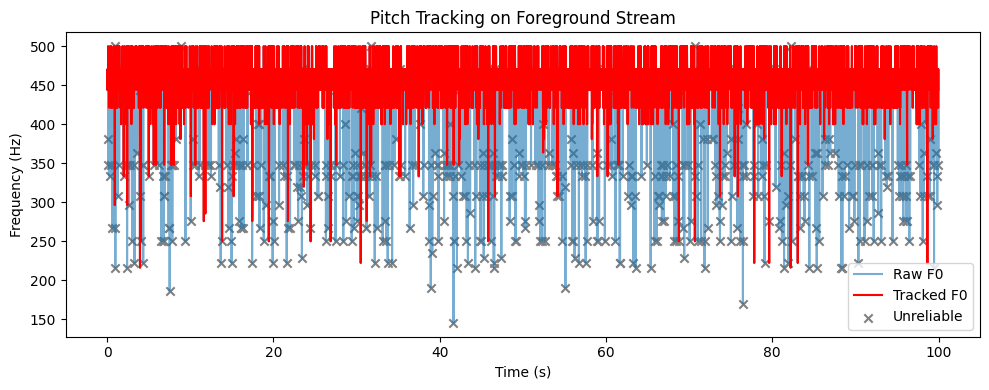

In [31]:
import numpy as np

# --- 앞단계에서 계산된 변수들 ---
# envelopes_lpf: (n_channels, T)
# auto_per_channel: (n_channels, n_lags)
# lags: (n_lags,)  # autocorr lag (samples)
# global_f0: scalar  # summary correlogram에서 뽑은 전역 피치(Hz)
# sr: scalar         # 샘플링 레이트
# foreground: list of segments from initial segregation

n_channels, T = envelopes_lpf.shape

# 1) Foreground mask: 어떤 채널·프레임이 foreground에 속하는지 표시
fg_mask = np.zeros((n_channels, T), dtype=bool)
for seg in foreground:
    chs = seg['channels']
    s, e = seg['start'], seg['end']
    fg_mask[chs, s:e+1] = True

# 2) Frame-by-frame raw pitch period estimation
#    plausible lag 범위 (2ms ~ 12.5ms)
min_lag = int(0.002 * sr)
max_lag = int(0.0125 * sr)
plausible = (lags >= min_lag) & (lags <= max_lag)
lags_pl = lags[plausible]

raw_period = np.full(T, np.nan)
for j in range(T):
    chs = np.where(fg_mask[:, j])[0]
    if chs.size == 0:
        continue
    # 채널별 autocorr 합산
    summary = auto_per_channel[chs][:, plausible].sum(axis=0)
    best = np.argmax(summary)
    raw_period[j] = lags_pl[best] / sr  # 초 단위

# 3) Constraint 1: 단위 유닛 동의율 검사 (θd=0.95)
theta_d = 0.95
reliable = np.zeros(T, dtype=bool)
for j in range(T):
    if np.isnan(raw_period[j]):
        continue
    tau_j = raw_period[j] * sr  # 샘플 단위 lag
    chs = np.where(fg_mask[:, j])[0]
    agree = 0
    for i in chs:
        Ai = auto_per_channel[i]
        # τ(j) 인덱스
        idx_j = np.argmin(np.abs(lags - tau_j))
        # τ_m (채널별 최대 피크) 인덱스
        idx_m = np.argmax(Ai[plausible])
        if Ai[idx_j] / Ai[plausible][idx_m] > theta_d:
            agree += 1
    if agree > (chs.size / 2):
        reliable[j] = True

# 4) Constraint 2: 시간적 연속성 (연속 프레임 간 20% 이내)
for j in range(1, T):
    if reliable[j] and reliable[j-1]:
        if abs(raw_period[j] - raw_period[j-1]) > 0.2 * raw_period[j-1]:
            reliable[j] = False

# 5) 불신뢰 프레임 보정 (forward-fill)
tracked = raw_period.copy()
for j in range(T):
    if not reliable[j] and j>0:
        tracked[j] = tracked[j-1]

# 6) Hz 단위로 변환
f0_tracked = 1.0 / tracked  # NaN은 그대로 NaN

# --- 결과 시각화 (선택) ---
import matplotlib.pyplot as plt

times = np.arange(T) * (hop_time := 0.010)  # hop_time = 10ms
plt.figure(figsize=(10,4))
plt.plot(times, 1.0/raw_period,    label='Raw F0',    alpha=0.6)
plt.plot(times, f0_tracked,         label='Tracked F0', color='red', linewidth=1.5)
plt.scatter(times[~reliable], 1.0/raw_period[~reliable],
            c='gray', marker='x', label='Unreliable')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Tracking on Foreground Stream')
plt.legend()
plt.tight_layout()
plt.show()


##  Unit Labeling (Periodicity & AM criterion)

In [33]:
from tqdm import tqdm
import numpy as np
from scipy.signal import firwin, lfilter, hilbert

# Assumed variables from previous steps:
# band_signals, raw_period, f0_tracked, auto_per_channel,
# lags, fg_mask, hop_length, frame_length, sr, theta_d, theta_f
frame_length = int(0.020 * sr)
theta_f = 0.12
n_channels, n_samples = band_signals.shape
_, T = fg_mask.shape
hop_length = int(0.010 * sr)


# Precompute plausible lag indices once
min_lag = int(0.002 * sr)
max_lag = int(0.0125 * sr)
plausible_idxs = np.where((lags >= min_lag) & (lags <= max_lag))[0]

# Pre-generate sine table for grid search (speeds up inner loop)
f_search = np.linspace(80, 500, 421)
t_vec = np.arange(frame_length) / sr
sin_table = np.sin(2 * np.pi * np.outer(f_search, t_vec))  # shape: (421, frame_length)

unit_label = np.zeros((n_channels, T), dtype=bool)

# Wrap outer loop with tqdm for progress visualization
for i in tqdm(range(n_channels), desc="Channels"):
    Ai = auto_per_channel[i]
    tau_m_idx = plausible_idxs[np.argmax(Ai[plausible_idxs])]
    
    # Inner loop also with tqdm, disabled leave to reduce clutter
    for j in tqdm(range(T), desc="Frames", leave=False):
        if np.isnan(raw_period[j]):
            continue
        lag_j = int(round(raw_period[j] * sr))
        
        # Periodicity Criterion
        if fg_mask[i, j]:
            if min_lag <= lag_j <= max_lag and Ai[lag_j] / Ai[tau_m_idx] > theta_d:
                unit_label[i, j] = True
            continue
        
        # AM Criterion
        start = j * hop_length
        end = start + frame_length
        if end > n_samples:
            continue
        x = band_signals[i, start:end]
        x_rect = np.maximum(x, 0)
        
        f_center = f0_tracked[j]
        if np.isnan(f_center):
            continue
        fmin_bp = max(80, 0.8 * f_center)
        fmax_bp = min(sr/2 - 1, 1.2 * f_center)
        bp_coefs = firwin(101, [fmin_bp, fmax_bp], pass_zero=False, fs=sr)
        x_bp = lfilter(bp_coefs, [1.0], x_rect)
        
        env_bp = np.abs(hilbert(x_bp))
        rhat = x_bp / (env_bp + 1e-8)
        
        # Compute grid search errors using precomputed sine table
        errors = np.mean((rhat - sin_table)**2, axis=1)
        idx_best = np.argmin(errors)
        f_ij = f_search[idx_best]
        min_mse = errors[idx_best]
        energy = np.mean(rhat**2)
        
        if (min_mse < 0.5 * energy) and (abs(f_ij * raw_period[j] - 1) < theta_f):
            unit_label[i, j] = True

# unit_label now contains the labeled mask



Channels: 100%|██████████| 128/128 [01:08<00:00,  1.88it/s]


In [34]:
import numpy as np
import soundfile as sf

# --- Assumed available from previous steps ---
# band_signals: (n_channels, n_samples) - raw gammatone filter outputs
# unit_label:   (n_channels, T)          - final T-F unit mask from Unit Labeling
# hop_length:   int                      - frame hop in samples (e.g. int(0.010 * sr))
# frame_length: int                      - frame length in samples (e.g. int(0.020 * sr))
# sr:           int                      - sampling rate in Hz

n_channels, n_samples = band_signals.shape
_, T = unit_label.shape

# 1) Create a sample-level mask for each band
band_mask = np.zeros_like(band_signals)

for i in range(n_channels):
    for j in range(T):
        if unit_label[i, j]:
            start = j * hop_length
            end = start + frame_length
            if end > n_samples:
                end = n_samples
            band_mask[i, start:end] = 1

# 2) Apply mask to band_signals and sum across channels
masked_bands = band_signals * band_mask
resynth = masked_bands.sum(axis=0)

# 3) Normalize output to [-1, 1]
resynth = resynth / np.max(np.abs(resynth))

# 4) Save as WAV
output_path = 'resynthesized_target.wav'
sf.write(output_path, resynth, sr)

print(f"Resynthesized waveform saved to {output_path}")



Resynthesized waveform saved to resynthesized_target.wav
